### Imports, initialization of constants, general set up

In [1]:
import os
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

# change to 'True' to perform: model finetuning, embeddings extraction, indexing, search and evalutaion; otherwise only plots from current results are shown
RUN_COMPUTATIONS = False

DATASETS = ["cacm", "med", "npl"]
TREC_EVAL_COMMAND = "trec_eval"

### Plotting functions

In [2]:
def scatter_plot(result_file_names, axis_descriptions, title, fig_filename=""):
    figure, axis = plt.subplots(1, 3, figsize=(14, 5))
    for i, dataset in enumerate(DATASETS):
        # load results from trec_eval format
        x = pd.read_csv(result_file_names[0] % dataset, sep="\t", header=None).sort_values(by=[1])[2].to_numpy()
        y = pd.read_csv(result_file_names[1] % dataset, sep="\t", header=None).sort_values(by=[1])[2].to_numpy()

        # plot the results nicely
        axis[i].set_aspect(1)
        axis[i].scatter(x[:-1], y[:-1], c="m", label="Score for each query")
        axis[i].scatter(x[-1], y[-1], s=[200], c="c", label="Average score")
        axis[i].plot(np.linspace(-0.025, 1.025), np.linspace(-0.025, 1.025), label="Identity line", c="orange", alpha=0.75)
        axis[i].set_xlim(-0.025, 1.025)
        axis[i].set_ylim(-0.025, 1.025)
        axis[i].set_xlabel(axis_descriptions[0])
        axis[i].set_ylabel(axis_descriptions[1])
        axis[i].set_title(f"{dataset} dataset")
        axis[i].legend()
    
    # remove unnecessary white space on the plot
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.91)
    figure.suptitle(title, fontsize=16)

    # save the plot if a file is specified
    if fig_filename:
        plt.savefig(fig_filename, dpi=300)
    plt.show()


def bar_chart_plot(x_input_template, y_input_template, legend_names, barchart_name, fig_filename=""):
    # Create an empty list to store the data frames
    df_list_one = []
    df_list_two = []

    # Iterate over the input files
    for dataset in DATASETS:
        # Read the file into a data frame
        df = pd.read_csv(x_input_template % dataset, sep='\t', names=['map', 'index', 'value'])

        # Extract the rows with the 'all' index
        df_all = df[df['index'] == 'all']
        value = df_all['value'].iloc[0]
        # Add the data frame to the list
        df_list_one.append(value)

        # Read the file into a data frame
        df = pd.read_csv(y_input_template % dataset, sep='\t', names=['map', 'index', 'value'])

        # Extract the rows with the 'all' index
        df_all = df[df['index'] == 'all']
        value = df_all['value'].iloc[0]
        # Add the data frame to the list
        df_list_two.append(value)


    # Create a data frame with the values and names
    df = pd.DataFrame({'values_one': df_list_one, 'values_two': df_list_two, 'names': DATASETS})

    # Set the bar width
    bar_width = 0.4

    # Calculate the x-coordinates for the bars
    x = range(len(df))

    # Create the plot
    fig, ax = plt.subplots()
    ax.bar(x, df['values_one'], width=bar_width, label=legend_names[0], color='m')
    ax.bar([i + bar_width for i in x], df['values_two'], width=bar_width, label=legend_names[1], color='c')
    ax.set_ylabel("Mean Average Precision")
    ax.set_title(barchart_name)
    ax.set_xticks([i + bar_width / 2 for i in x], df['names'])
    ax.legend()

    if fig_filename:
        plt.savefig(fig_filename, dpi=300)
    plt.show()

def bar_chart_plot_4_in_1(x_input_templates, y_input_templates, legend_names, barchart_name, fig_filename=""):
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    for i, (x_input_template, y_input_template) in enumerate(zip(x_input_templates, y_input_templates)):
        # Create an empty list to store the data frames
        df_list_one = []
        df_list_two = []

        # Iterate over the input files
        for dataset in DATASETS:
            # Read the file into a data frame
            df = pd.read_csv(x_input_template % dataset, sep='\t', names=['map', 'index', 'value'])

            # Extract the rows with the 'all' index
            df_all = df[df['index'] == 'all']
            value = df_all['value'].iloc[0]
            # Add the data frame to the list
            df_list_one.append(value)

            # Read the file into a data frame
            df = pd.read_csv(y_input_template % dataset, sep='\t', names=['map', 'index', 'value'])

            # Extract the rows with the 'all' index
            df_all = df[df['index'] == 'all']
            value = df_all['value'].iloc[0]
            # Add the data frame to the list
            df_list_two.append(value)


        # Create a data frame with the values and names
        df = pd.DataFrame({'values_one': df_list_one, 'values_two': df_list_two, 'names': DATASETS})

        # Set the bar width
        bar_width = 0.4

        # Calculate the x-coordinates for the bars
        x = range(len(df))

        # Create the plot
        j = i // 2
        k = i & 1
        ax[j, k].bar(x, df['values_one'], width=bar_width, label=legend_names[i][0], color='m')
        ax[j, k].bar([i + bar_width for i in x], df['values_two'], width=bar_width, label=legend_names[i][1], color='c')
        ax[j, k].set_ylabel("Mean Average Precision")
        ax[j, k].set_xticks([i + bar_width / 2 for i in x], df['names'])
        ax[j, k].legend()

    fig.suptitle(barchart_name, fontsize=16)
    plt.subplots_adjust(left=0.055, bottom=0.03, right=0.985, top=0.95, hspace=0.08, wspace=0.15)

    if fig_filename:
        plt.savefig(fig_filename, dpi=300)
    plt.show()

## Reference
We chose the BM-25 search as our reference fro all tasks.

In [59]:
if RUN_COMPUTATIONS:
    for dataset in DATASETS:
        # indexing documents
        os.system(f"python3 bm25_index.py -f ./data/{dataset}/{dataset}.json -i bm25_{dataset} -v 0")
        
        # running search on the indexed documents using queries converted to embeddings
        os.system(f"python3 bm25_search.py -q ./data/{dataset}/queries.json -i bm25_{dataset} -o ./bm25_reference/outputs/bm25_{dataset}.txt")
        
        # evaluating the search results with trec_eval
        os.system(f"{TREC_EVAL_COMMAND} -m map -q ./data/{dataset}/qrels-treceval.txt ./bm25_reference/outputs/bm25_{dataset}.txt"
                  f" > ./bm25_reference/results/map_bm25_{dataset}.txt")

## Task 01
In this task we compared BM-25 search with cosine similarity search using embeddings created by different sentence transformers.

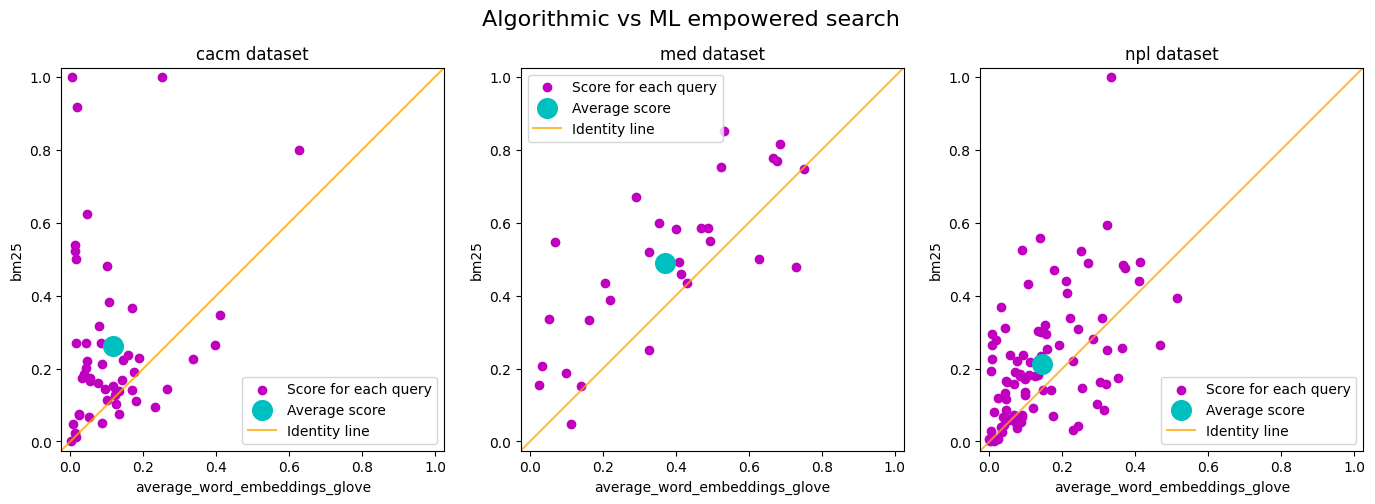

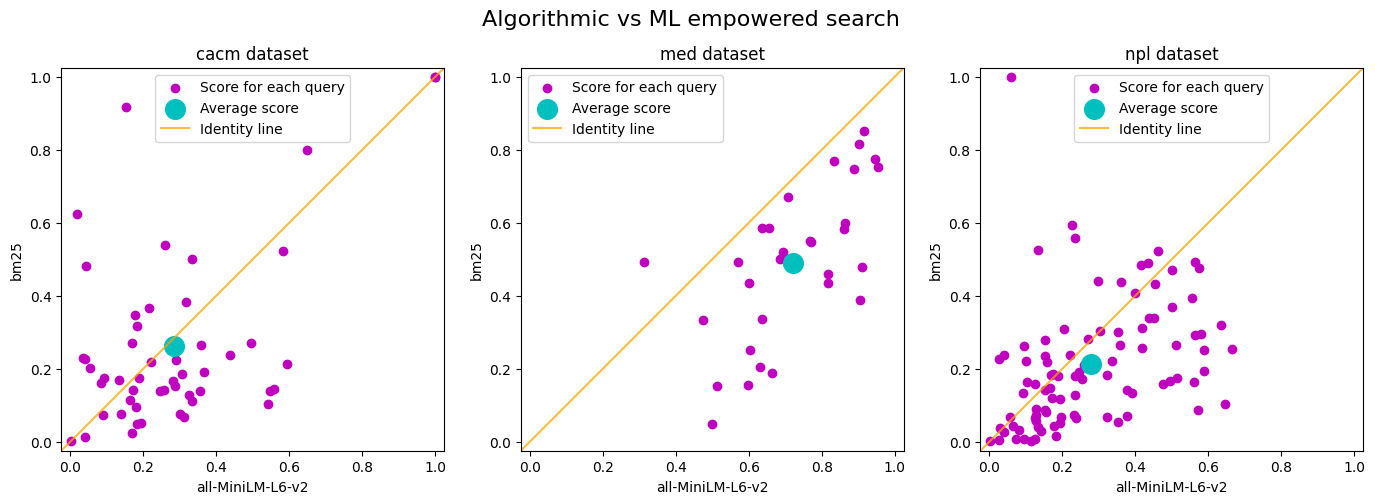

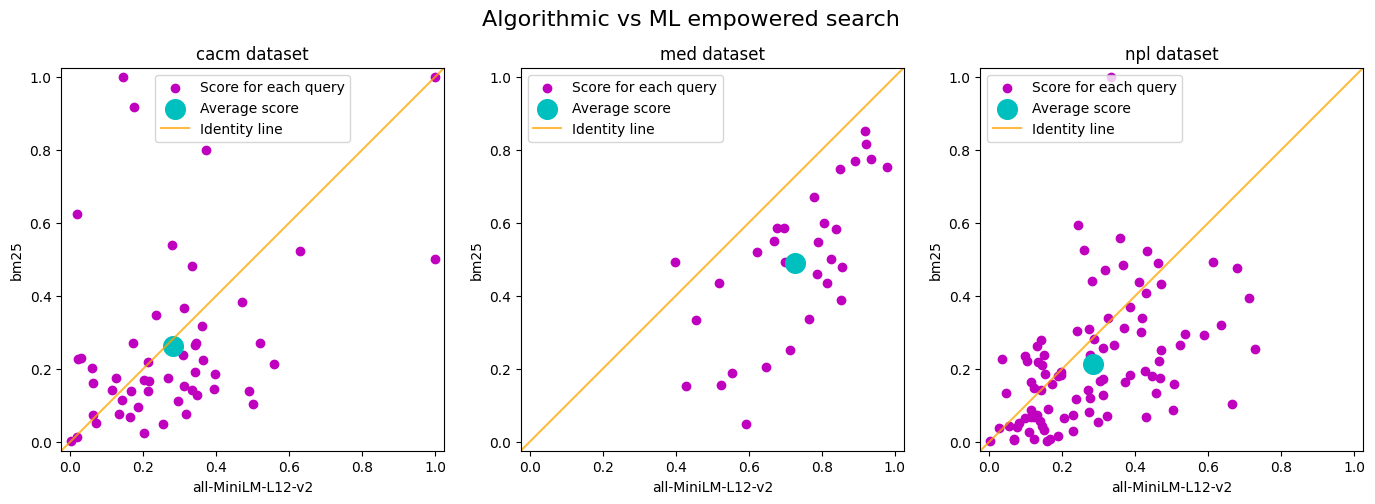

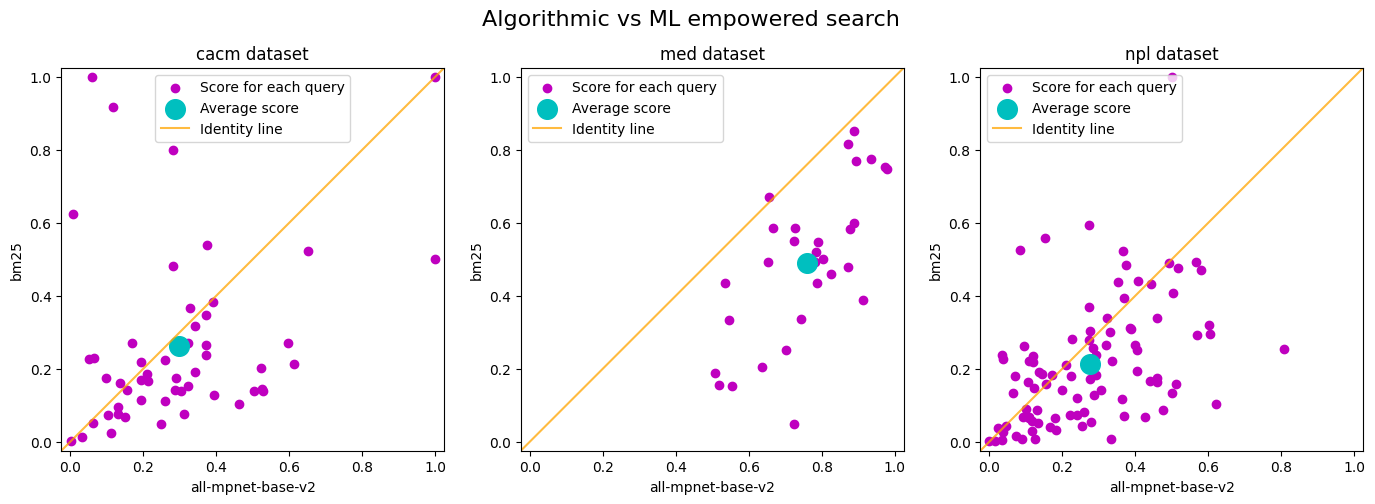

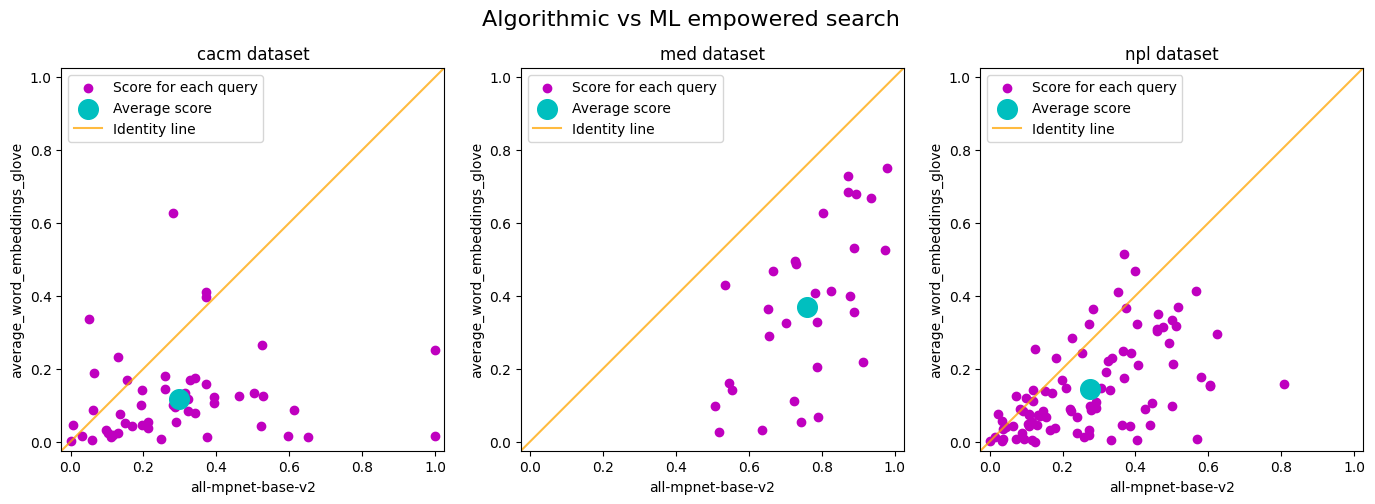

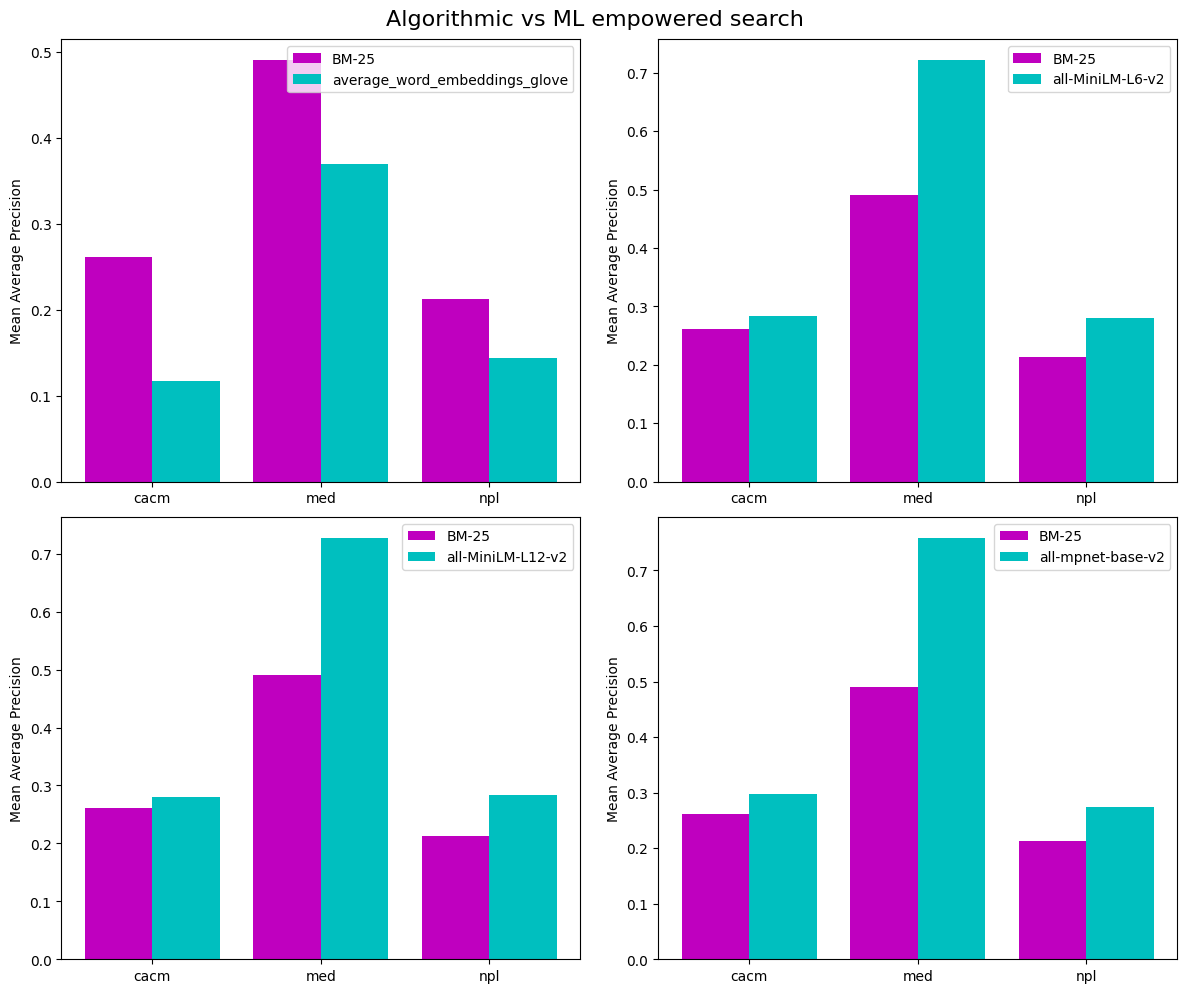

In [60]:
MODEL_SHORTCUTS = ["glove", "minil6", "minil12", "mpnetv2"]
MODEL_NAMES = ["average_word_embeddings_glove.6B.300d", "all-MiniLM-L6-v2", "all-MiniLM-L12-v2", "all-mpnet-base-v2"]

if RUN_COMPUTATIONS:
    for dataset in DATASETS:
        for model_name, model_shortcut in zip(MODEL_NAMES, MODEL_SHORTCUTS):
            # indexing documents converted to embeddings into elasticsearch
            os.system(f"python3 embedding_index.py -f ./data/{dataset}/{dataset}.json -i {model_shortcut}_{dataset} -m {model_name} -v 0")
            
            # running search on the indexed documents using queries converted to embeddings
            os.system(f"python3 embedding_search.py -q ./data/{dataset}/queries.json -i {model_shortcut}_{dataset} -m {model_name} -o ./task_01/outputs/{model_shortcut}_{dataset}.txt")
            
            # evaluating the search results with trec_eval
            os.system(f"{TREC_EVAL_COMMAND} -m map -q ./data/{dataset}/qrels-treceval.txt ./task_01/outputs/{model_shortcut}_{dataset}.txt > ./task_01/results/map_{model_shortcut}_{dataset}.txt")

# glove vs BM-25
scatter_plot(["./task_01/results/map_glove_%s.txt", "./bm25_reference/results/map_bm25_%s.txt"], 
                             ["average_word_embeddings_glove", "bm25"], "Algorithmic vs ML empowered search", "presentation/figures/glove_vs_bm25")

# minil6 vs BM-25
scatter_plot(["./task_01/results/map_minil6_%s.txt", "./bm25_reference/results/map_bm25_%s.txt"], 
                             ["all-MiniLM-L6-v2", "bm25"], "Algorithmic vs ML empowered search", "presentation/figures/minil6_vs_bm25")

# minil12 vs BM-25
scatter_plot(["./task_01/results/map_minil12_%s.txt", "./bm25_reference/results/map_bm25_%s.txt"], 
                             ["all-MiniLM-L12-v2", "bm25"], "Algorithmic vs ML empowered search", "presentation/figures/minil12_vs_bm25")

# mpnetv2 vs BM-25
scatter_plot(["./task_01/results/map_mpnetv2_%s.txt", "./bm25_reference/results/map_bm25_%s.txt"], 
                             ["all-mpnet-base-v2", "bm25"], "Algorithmic vs ML empowered search", "presentation/figures/mpnetv2_vs_bm25")

# glove vs mpnetv2
scatter_plot(["./task_01/results/map_mpnetv2_%s.txt", "./task_01/results/map_glove_%s.txt"], 
                             ["all-mpnet-base-v2", "average_word_embeddings_glove"], "Algorithmic vs ML empowered search", "presentation/figures/glove_vs_mpnetv2")

bar_chart_plot_4_in_1(["./bm25_reference/results/map_bm25_%s.txt"] * 4, 
                      ["./task_01/results/map_glove_%s.txt", "./task_01/results/map_minil6_%s.txt", "./task_01/results/map_minil12_%s.txt", 
                       "./task_01/results/map_mpnetv2_%s.txt"], 
                      [["BM-25", "average_word_embeddings_glove"], ["BM-25", "all-MiniLM-L6-v2"], ["BM-25", "all-MiniLM-L12-v2"], ["BM-25", "all-mpnet-base-v2"]],
                      "Algorithmic vs ML empowered search", "presentation/figures/task_01_bar_plot")

## Task 02
In this task we use Google Pegasus to summarize the data and compare the results of the unsummarized and summarized using BM-25.

ValueError: x and y must be the same size

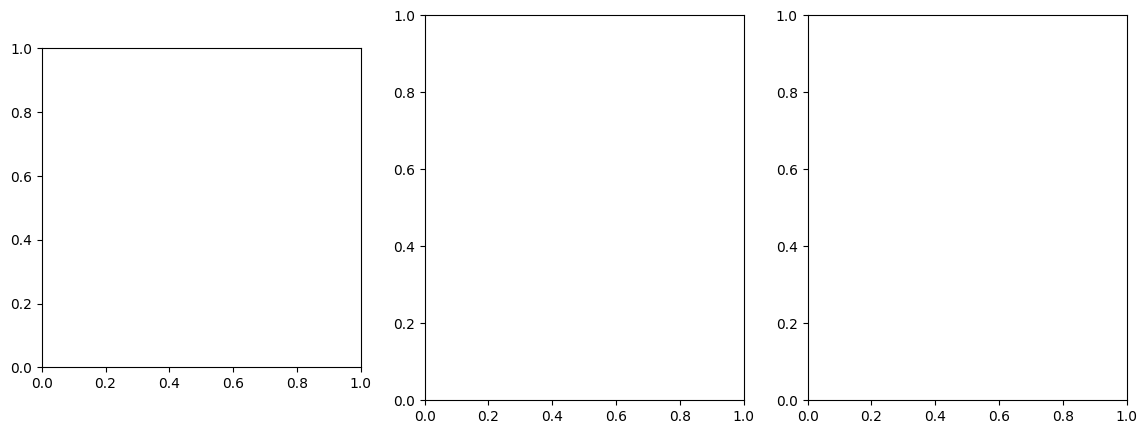

In [61]:
if RUN_COMPUTATIONS:
    for dataset in DATASETS:
        # summarazing documents
        os.system(f"python3 summarize_data.py {dataset}")
    
        # indexing summarized documents using elasticsearch 
        os.system(f"python3 bm25_index.py -f ./data/{dataset}/{dataset}_summarize_en.json -i summarized_{dataset} -v 0")
        
        # running search on the indexed documents using text queries
        os.system(f"python3 bm25_search.py -q ./data/{dataset}/queries.json -i summarized_{dataset} -o ./task_02/outputs/summarized_{dataset}.txt")
        
        # evaluating the search results with trec_eval
        os.system(f"{TREC_EVAL_COMMAND} -m map -q ./data/{dataset}/qrels-treceval.txt ./task_02/outputs/summarized_{dataset}.txt"
                  f" > ./task_02/results/map_summarized_{dataset}.txt")

# not summarized vs summarized
scatter_plot(["./task_02/results/map_summarized_%s.txt", "./bm25_reference/results/map_bm25_%s.txt"], 
                             ["summarized bm25", "bm25"], "Summarized and not summarized search comparison", "presentation/figures/summarized_bm25_vs_bm25")
bar_chart_plot("./bm25_reference/results/map_bm25_%s.txt", "./task_02/results/map_summarized_%s.txt", ["Not summarized", "Summarized"],
               "Summarized and not summarized search comparison", "presentation/figures/summarized_bm25_vs_bm25_bar")

## Task 03
TODO

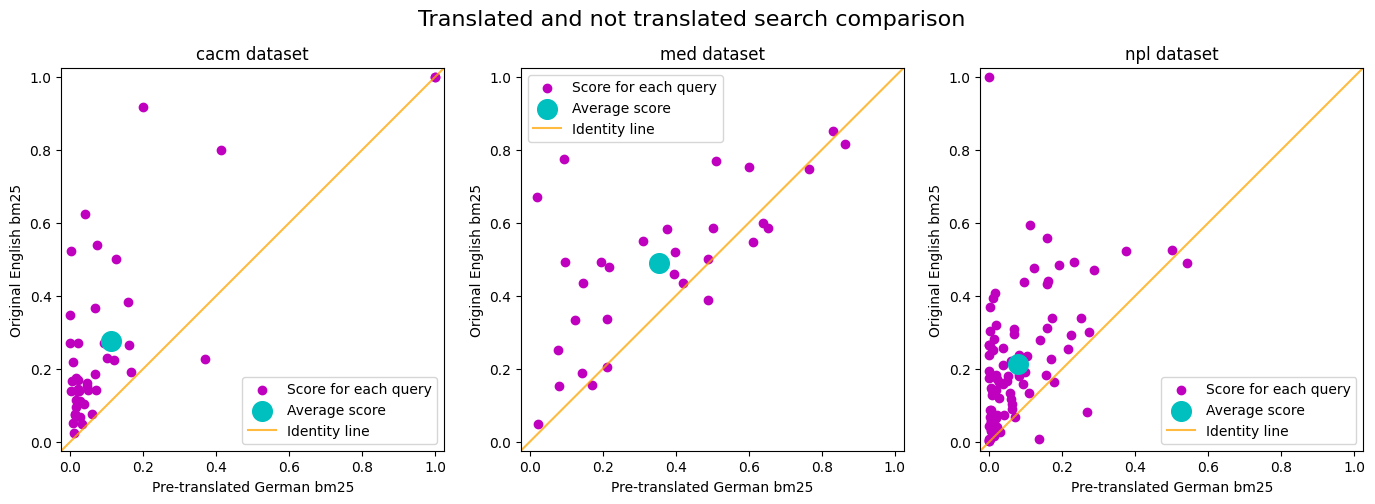

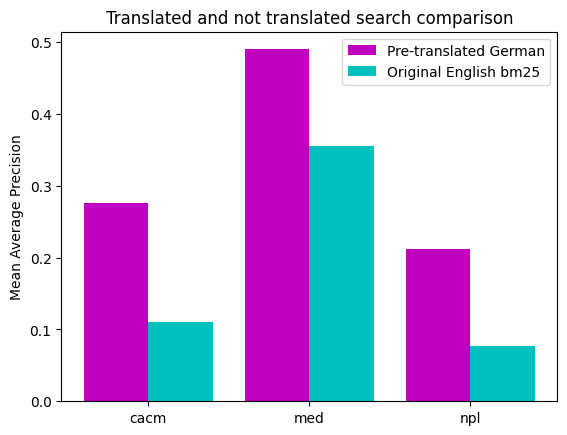

In [ ]:
if RUN_COMPUTATIONS:
    for dataset in DATASETS:
        # indexing pre-translated documents using elasticsearch 
        os.system(f"python3 bm25_index.py -f ./data/{dataset}/ger_{dataset}.json -i ger_{dataset}_bm25 -v 0")
        
        # running search on the indexed documents using text queries
        os.system(f"python3 bm25_search.py -q ./data/{dataset}/queries.json -i ger_{dataset}_bm25 -o ./task_03/outputs/ger_{dataset}.txt")
        
        # evaluating the search results with trec_eval
        os.system(f"{TREC_EVAL_COMMAND} -m map -q ./data/{dataset}/qrels-treceval.txt ./task_03/outputs/ger_{dataset}.txt"
                  f" > ./task_03/results/map_ger_{dataset}.txt")

# translated vs not translated
scatter_plot(["./task_03/results/map_ger_%s.txt", "./bm25_reference/results/map_bm25_%s.txt"], 
                             ["Pre-translated German bm25", "Original English bm25"], "Translated and not translated search comparison", 
                             "presentation/figures/translated_not_translated_bm25")
bar_chart_plot("./bm25_reference/results/map_bm25_%s.txt", "./task_03/results/map_ger_%s.txt", ["Pre-translated German", "Original English bm25"],
               "Translated and not translated search comparison", "presentation/figures/translated_not_translated_bm25_bar")

## Task 04
In this task we fine-tuned pre-trained multilingual sentence transformers and evaluated their performance on queries in different languages.

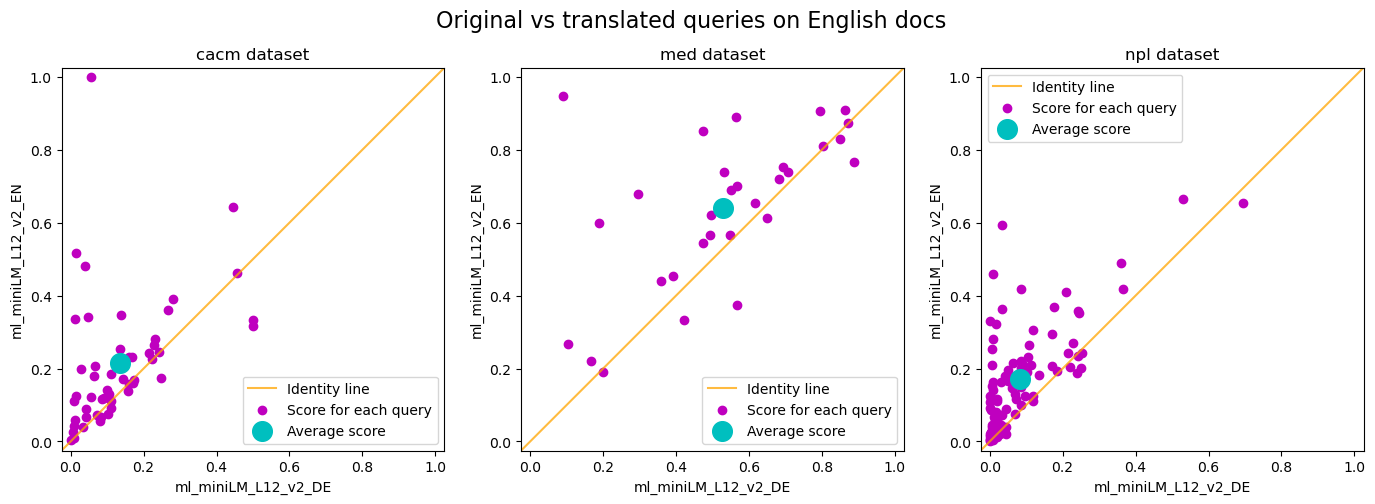

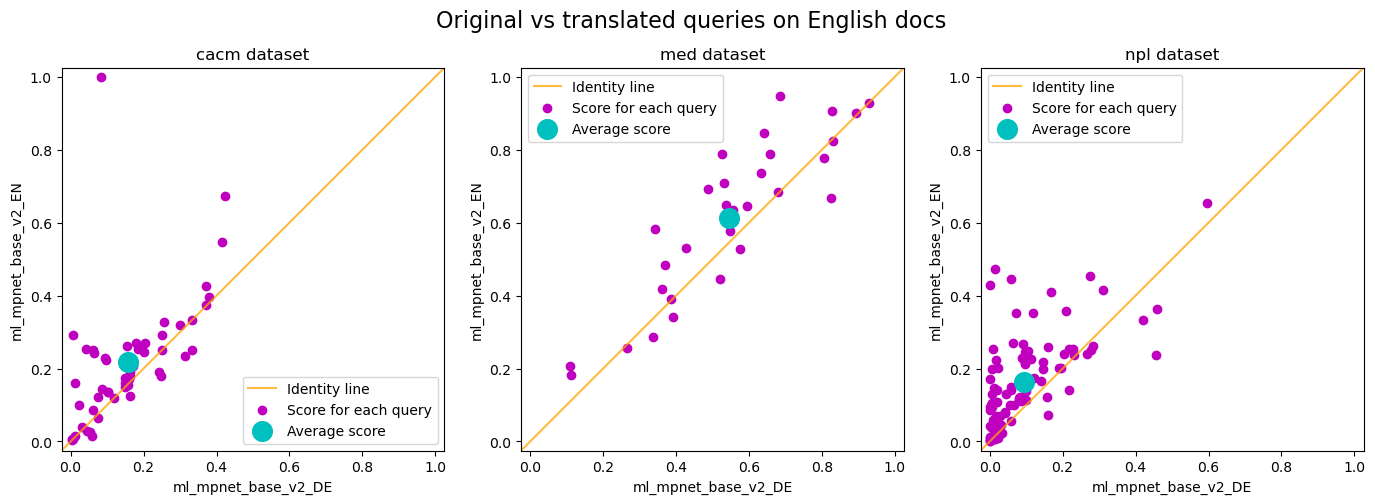

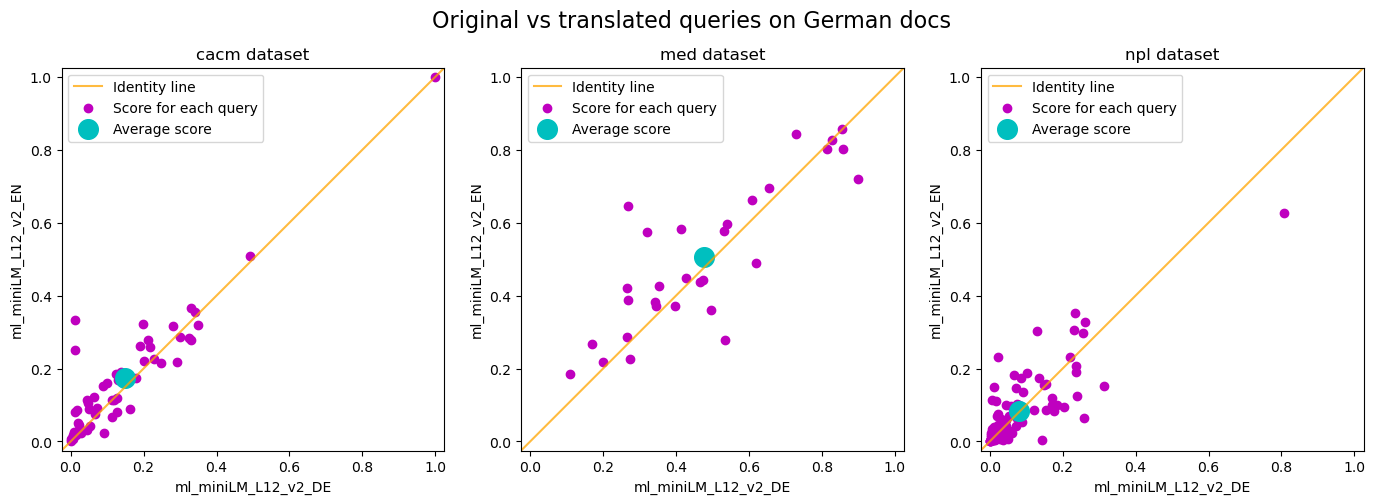

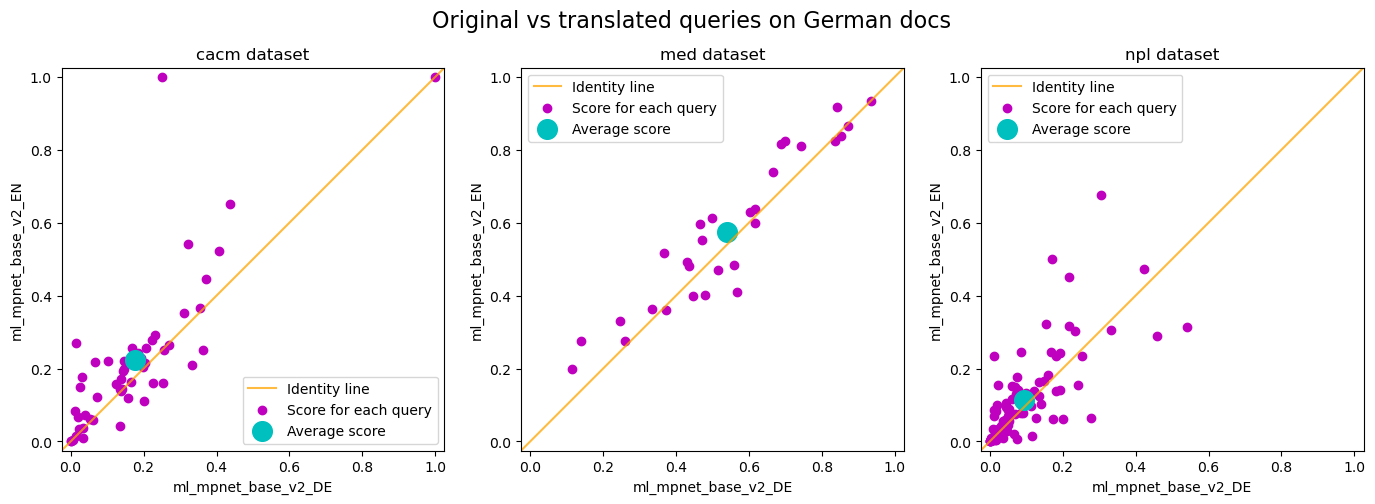

In [9]:
# multi-lingual sentence transformers models
MODELS = ["paraphrase-multilingual-MiniLM-L12-v2", "paraphrase-multilingual-mpnet-base-v2"]
MODEL_SHORTCUTS = ["ml_miniLM_L12_v2", "ml_mpnet_base_v2"]

LANGUAGES = ["EN", "DE"]

# model fine-tuning parameters
FINETUNE_ENABLED = False
MODEL_FOLDER = f"./task_04/models"
EPOCHS = 10
WARMUP_STEPS = 50
BATCH_SIZE = 16

if RUN_COMPUTATIONS:
    for dataset in DATASETS:
        for model, model_shortcut in zip(MODELS, MODEL_SHORTCUTS):
            # translate queries to target language
            for language in LANGUAGES:
                # see translate.py regarding DeepL API key
                os.system(f"python3 translate.py -l {language} -s ./data/{dataset}/queries.json -t ./data/{dataset}/queries_{language}.json -d ./deepl_auth.key")

            # fine-tune models on the data set
            model_path = f"{model}"
            if FINETUNE_ENABLED:
                model_path = f"{MODEL_FOLDER}/{model_shortcut}_{dataset}/"
                print(f"Fine-tuning {model} on {dataset}...")
                os.system(f"python3 finetune.py -m {model} -d ./data/{dataset}/{dataset}.json -f {model_path} -e {EPOCHS} -w {WARMUP_STEPS} -b {BATCH_SIZE}")

            # convert documents to embeddings and create index in ElasticSearch
            print(f"Embedding docs and creating index for {dataset}...")
            index = f"{model_shortcut.lower()}_{dataset}" + ("_finetuned" if FINETUNE_ENABLED else "_pretrained")
            os.system(f"python3 embedding_index.py -f ./data/{dataset}/{dataset}.json -i {index} -m {model_path} -v 0")

            # search on indexed documents using queries in target languages
            output_folder = "./task_04/outputs/" + ("finetuned" if FINETUNE_ENABLED else "pretrained")
            results_folder = "./task_04/results/" + ("finetuned" if FINETUNE_ENABLED else "pretrained")
            for language in LANGUAGES:
                os.system(f"python3 embedding_search.py -q ./data/{dataset}/queries_{language}.json -i {index} -m {model_path}"
                          f" -o {output_folder}/{model_shortcut}_{dataset}_{language}.txt")

                os.system(
                    f"trec_eval -m map -q ./data/{dataset}/qrels-treceval.txt {output_folder}/{model_shortcut}_{dataset}_{language}.txt"
                    f" > {results_folder}/map_{model_shortcut}_{dataset}_{language}.txt")

# compare performance of German queries vs English queries on English docs
for model_shortcut in MODEL_SHORTCUTS:
    scatter_plot([
        f"./task_04/results/pretrained/map_{model_shortcut}_%s_DE.txt",
        f"./task_04/results/pretrained/map_{model_shortcut}_%s_EN.txt"
    ], [f"{model_shortcut}_DE", f"{model_shortcut}_EN"], "Original vs translated queries on English docs",
                 f"presentation/figures/DE_vs_EN_{model_shortcut}_on_EN")

# bar_chart(f"./task_04/results/pretrained/map_{model_shortcut}_%s_DE.txt", f"./task_04/results/finetuned/map_{model_shortcut}_%s_EN.txt",
#                ["German (translated)", "English (original)"], "Original vs translated documents and queries", "presentation/figures/DE_vs_EN_bar")

# compare performance of German queries vs English queries on German docs
for model_shortcut in MODEL_SHORTCUTS:
    scatter_plot([
        f"./task_04/results/DE/map_{model_shortcut}_%s_DE.txt",
        f"./task_04/results/DE/map_{model_shortcut}_%s_EN.txt"
    ], [f"{model_shortcut}_DE", f"{model_shortcut}_EN"], "Original vs translated queries on German docs",
                 f"presentation/figures/DE_vs_EN_{model_shortcut}_on_DE")


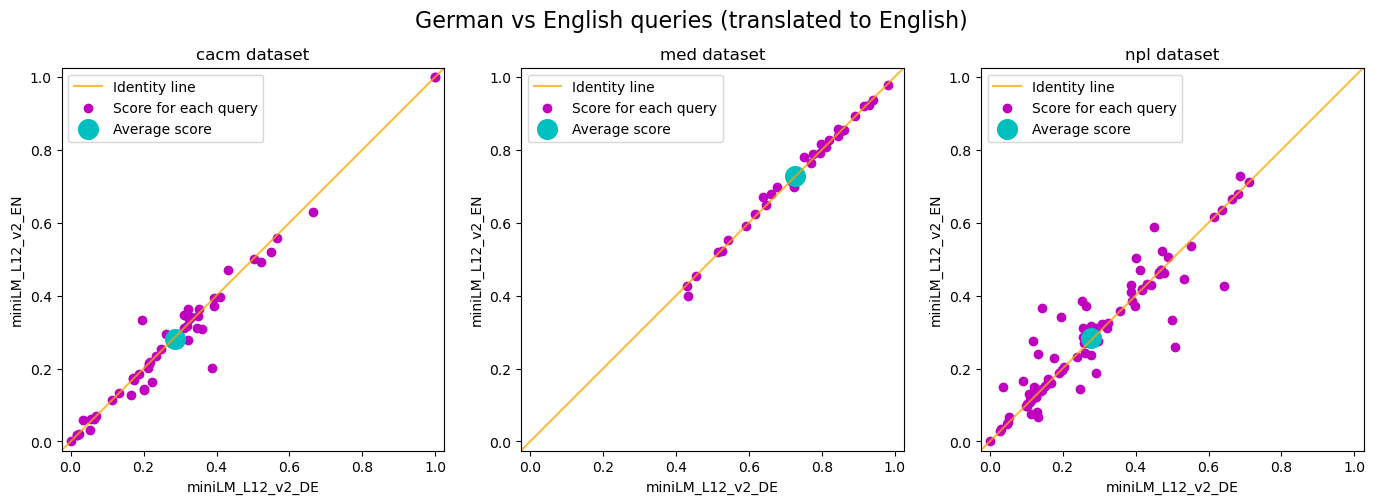

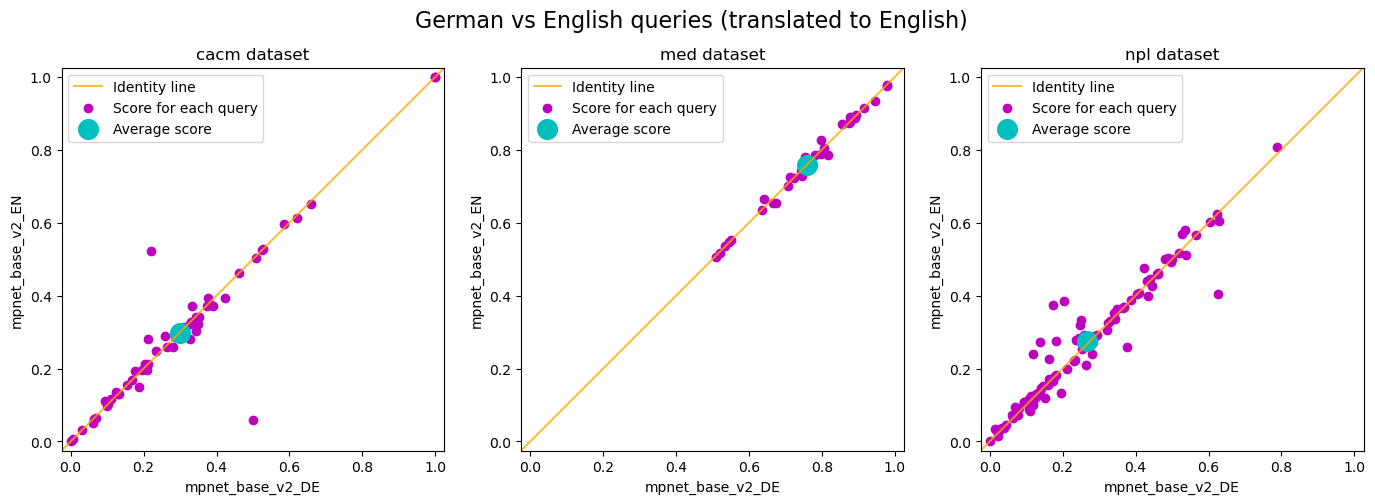

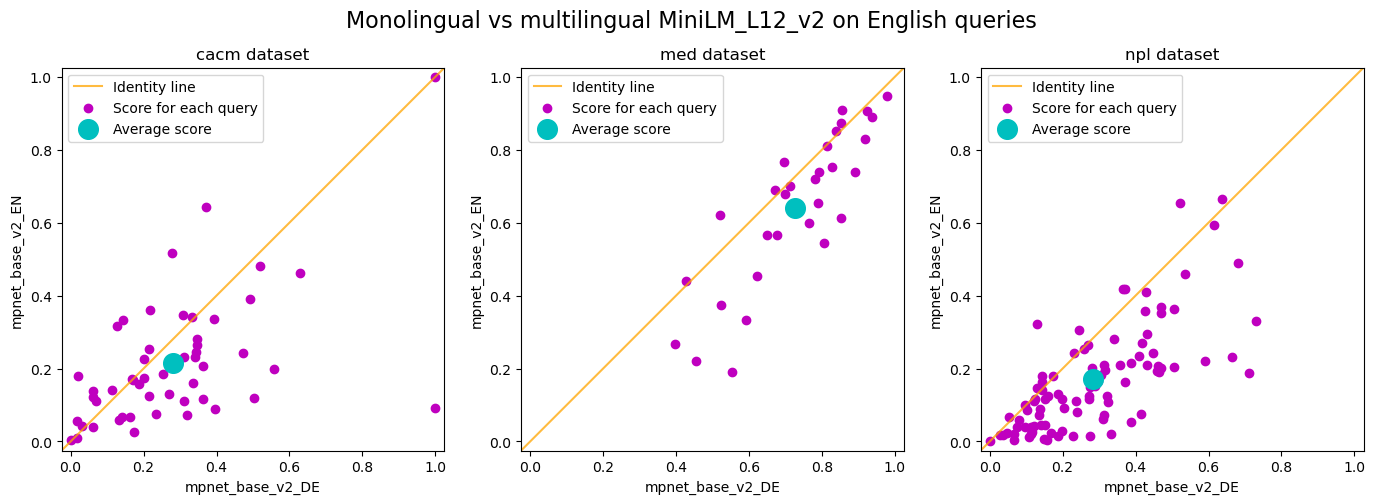

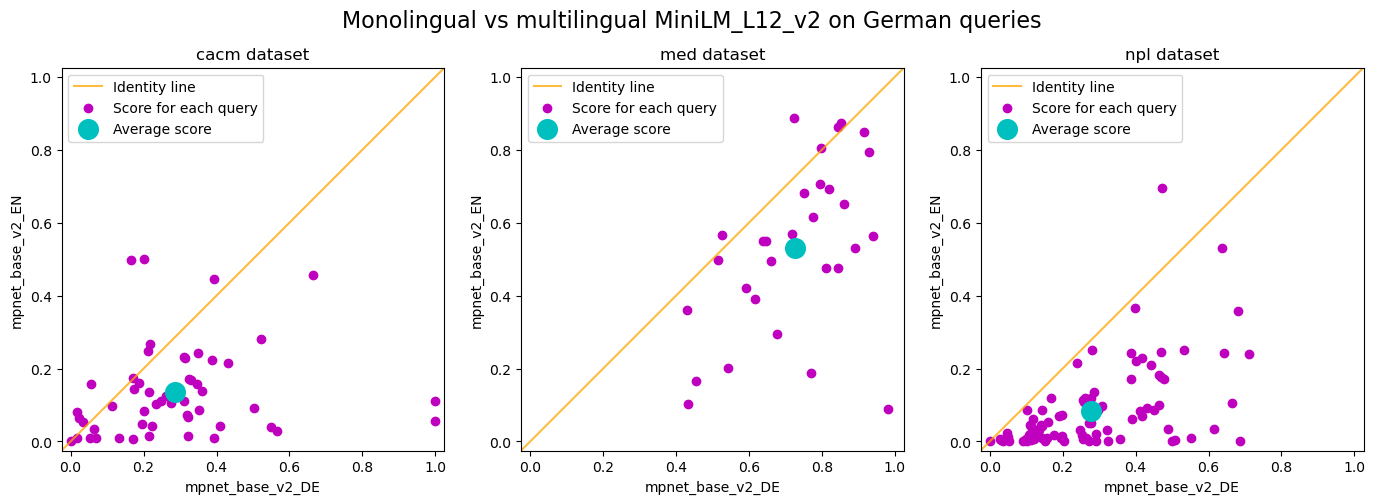

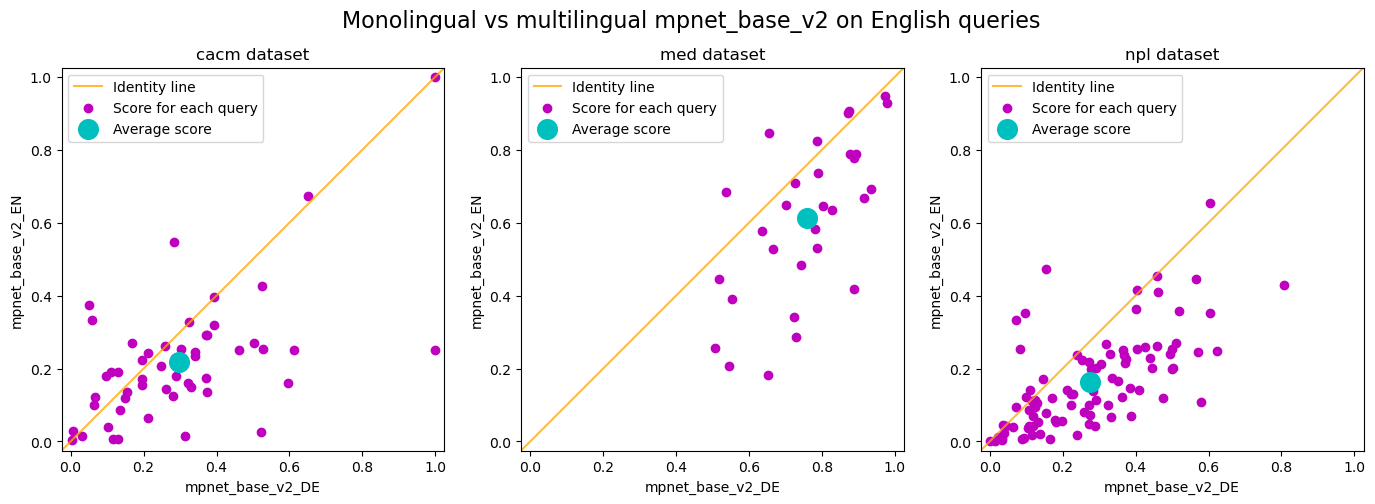

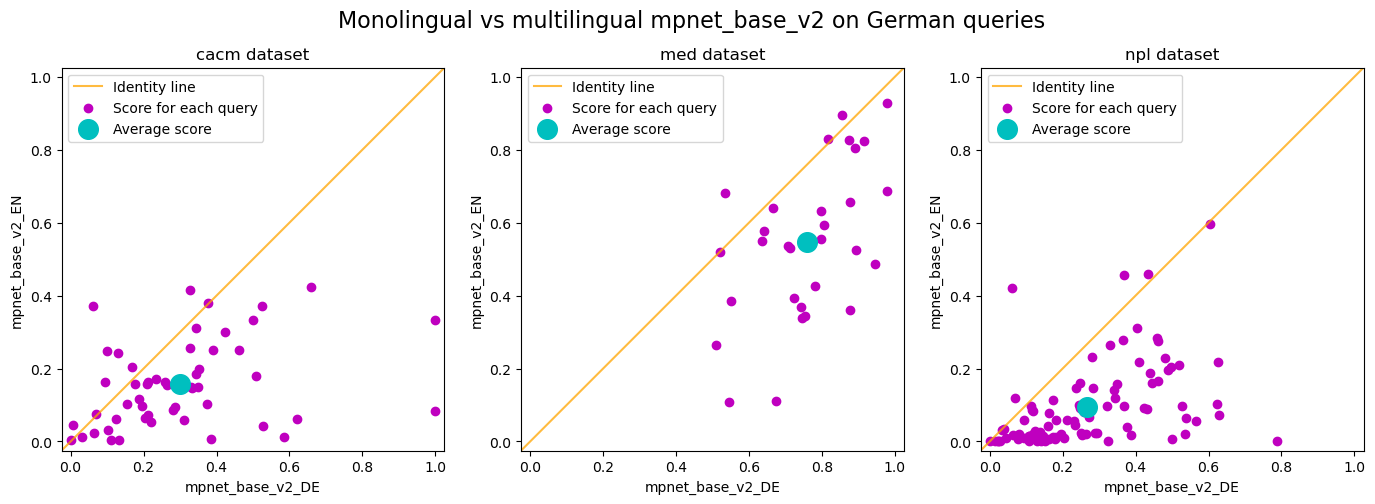

In [10]:
# mono-lingual sentence transformers models
MODELS = ["all-MiniLM-L12-v2", "all-mpnet-base-v2"]
MODEL_SHORTCUTS = ["miniLM_L12_v2", "mpnet_base_v2"]

LANGUAGES = ["EN", "DE"]

# use monolingual sentence transformers instead of multilingual
# translate queries to English before searching
if RUN_COMPUTATIONS:
    for dataset in DATASETS:
        for model, model_shortcut in zip(MODELS, MODEL_SHORTCUTS):
            # translate queries to English
            for language in LANGUAGES:
                os.system(f"python3 translate.py -l EN -s ./data/{dataset}/queries_{language}.json -t ./data/{dataset}/queries_from_{language}.json -d ./deepl_auth.key")

            # convert documents to embeddings and create index in ElasticSearch
            index = f"{model_shortcut.lower()}_{dataset}_monolingual"
            os.system(f"python3 embedding_index.py -f ./data/{dataset}/{dataset}.json -i {index} -m {model} -v 0")

            # search on indexed documents using English queries
            for language in LANGUAGES:
                os.system(
                    f"python3 embedding_search.py -q ./data/{dataset}/queries_from_{language}.json -i {index} -m {model}"
                    f" -o ./task_04/outputs/monolingual/{model_shortcut}_{dataset}_{language}.txt")

                os.system(
                    f"trec_eval -m map -q ./data/{dataset}/qrels-treceval.txt ./task_04/outputs/monolingual/{model_shortcut}_{dataset}_{language}.txt"
                    f" > ./task_04/results/monolingual/map_{model_shortcut}_{dataset}_{language}.txt")

# compare performance of German queries vs English queries (monolingual)
for model_shortcut in MODEL_SHORTCUTS:
    scatter_plot([
        f"./task_04/results/monolingual/map_{model_shortcut}_%s_DE.txt",
        f"./task_04/results/monolingual/map_{model_shortcut}_%s_EN.txt"
    ], [f"{model_shortcut}_DE", f"{model_shortcut}_EN"], "German vs English queries (translated to English)",
                 f"presentation/figures/DE_vs_EN_{model_shortcut}_monolingual")

# compare performance of monolingual models vs their multilingual counterparts
scatter_plot([
    f"./task_04/results/monolingual/map_miniLM_L12_v2_%s_EN.txt",   # monolingual
    f"./task_04/results/pretrained/map_ml_miniLM_L12_v2_%s_EN.txt" # multilingual
], [f"{model_shortcut}_DE", f"{model_shortcut}_EN"], "Monolingual vs multilingual MiniLM_L12_v2 on English queries",
             f"presentation/figures/DE_vs_EN_miniLM_L12_v2_vs_ml_miniLM_L12_v2_on_EN")

# compare performance of monolingual models vs their multilingual counterparts
scatter_plot(
    [
        f"./task_04/results/monolingual/map_miniLM_L12_v2_%s_DE.txt",  # monolingual
        f"./task_04/results/pretrained/map_ml_miniLM_L12_v2_%s_DE.txt"  # multilingual
    ],
    [f"{model_shortcut}_DE", f"{model_shortcut}_EN"],
    "Monolingual vs multilingual MiniLM_L12_v2 on German queries",
    f"presentation/figures/DE_vs_EN_miniLM_L12_v2_vs_ml_miniLM_L12_v2_on_DE")

# compare performance of monolingual models vs their multilingual counterparts
scatter_plot(
    [
        f"./task_04/results/monolingual/map_mpnet_base_v2_%s_EN.txt",  # monolingual
        f"./task_04/results/pretrained/map_ml_mpnet_base_v2_%s_EN.txt"  # multilingual
    ],
    [f"{model_shortcut}_DE", f"{model_shortcut}_EN"],
    "Monolingual vs multilingual mpnet_base_v2 on English queries",
    f"presentation/figures/DE_vs_EN_mpnet_base_v2_vs_ml_mpnet_base_v2_on_EN")

# compare performance of monolingual models vs their multilingual counterparts
scatter_plot(
    [
        f"./task_04/results/monolingual/map_mpnet_base_v2_%s_DE.txt",  # monolingual
        f"./task_04/results/pretrained/map_ml_mpnet_base_v2_%s_DE.txt"  # multilingual
    ],
    [f"{model_shortcut}_DE", f"{model_shortcut}_EN"],
    "Monolingual vs multilingual mpnet_base_v2 on German queries",
    f"presentation/figures/DE_vs_EN_mpnet_base_v2_vs_ml_mpnet_base_v2_on_DE")
